In [1]:
# This notebook runs from the projects root directory.
import os
PROJECT_ROOT_DIRECTORY = 'senior_project'
while os.path.basename(os.getcwd()) != PROJECT_ROOT_DIRECTORY:
    os.chdir(os.pardir)
print('Current working directory:', os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
from stable_baselines3 import DQN
from environments.discrete_env_v2 import PortfolioManagementEnv
from experiments.utils import evaluate_results

Current working directory: c:\Users\pavan\Desktop\senior_project


In [2]:
train_df = pd.read_csv('data\dow_10_stationary_features_train.csv', index_col=0, parse_dates=True)
val_df = pd.read_csv('data\dow_10_stationary_features_val.csv', index_col=0, parse_dates=True)
test_df = pd.read_csv('data\dow_10_stationary_features_test.csv', index_col=0, parse_dates=True)

TICKERS = ['AXP', 'AAPL', 'BA', 'GS', 'INTC', 'JNJ', 'KO', 'NKE', 'PG', 'DIS']
FEATURES = ['RETURN_12', 'RETURN_26', 'RETURN_60', 'STD_20']

RETURN_COLS = ['RISK_FREE'] + [ticker for ticker in TICKERS]
FEATURE_COLS = RETURN_COLS + [f'{ticker}_{feature}' for ticker in TICKERS for feature in FEATURES]

In [3]:
def evaluate_model(model, env):

    obs, done = env.reset(), False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)

    returns = env.get_portfolio_returns()

    annualized_mean_return = (1+returns).prod()**(252/len(returns)) - 1
    annualized_risk = (returns.var() * 252) ** 0.5
    sharpe_ratio = annualized_mean_return / annualized_risk

    return sharpe_ratio, returns

In [4]:
baselines = pd.read_csv('experiments/baselines_df.csv', index_col=0, parse_dates=True)
baselines_train = baselines.loc[train_df.index]
baselines_val = baselines.loc[val_df.index]
baselines_test = baselines.loc[test_df.index]

## Experiment 6

In [5]:
EXPERIMENTS_ID = 'EXPERIMENT_6_1678606705'

In [6]:
train_env = PortfolioManagementEnv(
    train_df, RETURN_COLS, FEATURE_COLS, window_size=10, episode_length=-1, drawdown_penalty_weight=1, allocations_in_obs=True
)

val_env = PortfolioManagementEnv(
    val_df, RETURN_COLS, FEATURE_COLS, window_size=10, episode_length=-1, drawdown_penalty_weight=1, allocations_in_obs=True
)

test_env = PortfolioManagementEnv(
    test_df, RETURN_COLS, FEATURE_COLS, window_size=10, episode_length=-1, drawdown_penalty_weight=1, allocations_in_obs=True
)

ENVIRONMENTS = (train_env, val_env, test_env)

  0%|          | 0/299 [00:00<?, ?it/s]

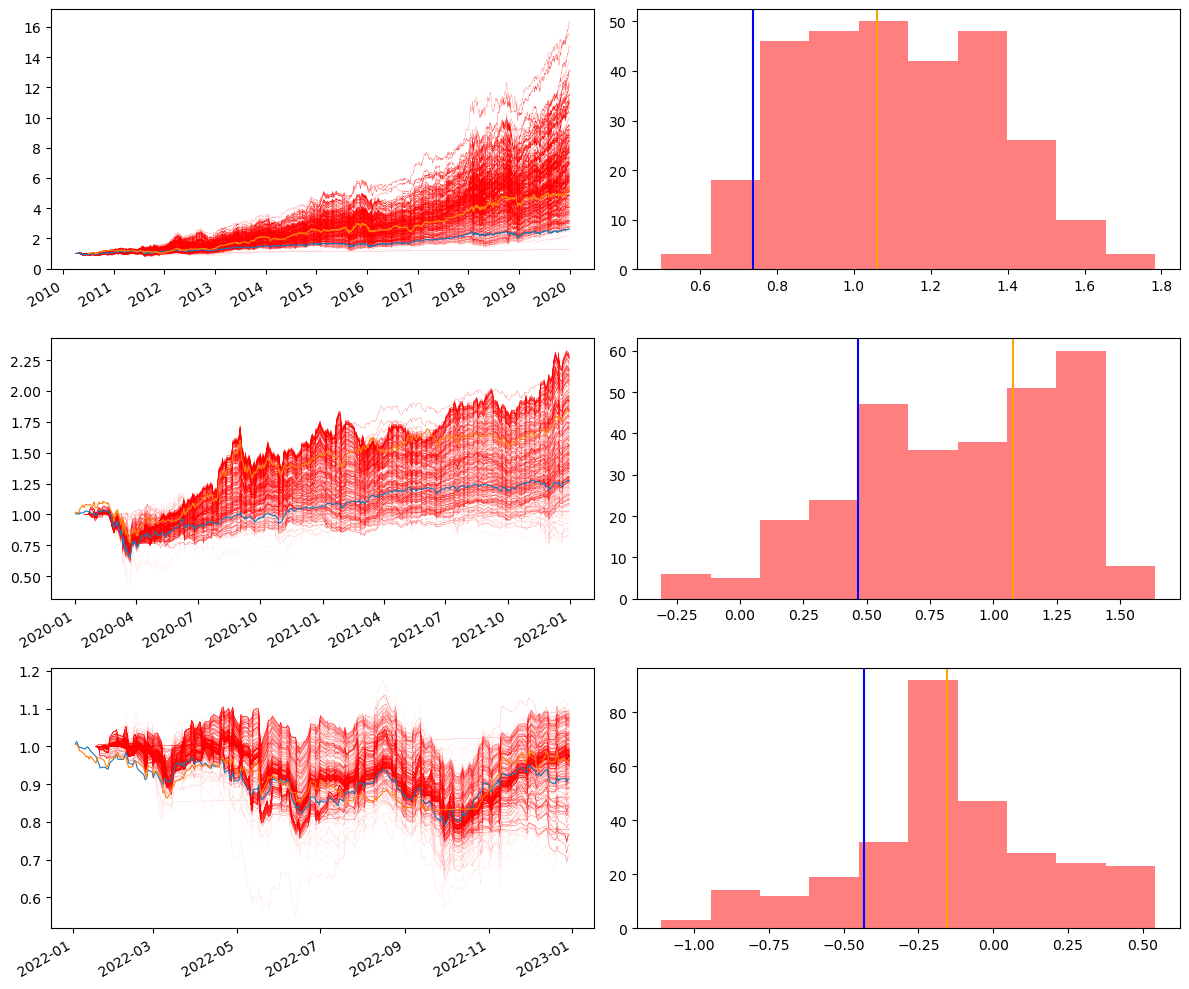

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(12,10))
warnings.filterwarnings('ignore')
start, end, step = 10_000, 3_000_000, 10_000
sharpes = [np.array([]), np.array([]), np.array([])]

for i in tqdm(range(start, end, step)):
    model = DQN.load(f'experiments/models/{EXPERIMENTS_ID}/{i}')
    for j, env in enumerate(ENVIRONMENTS):
        sharpe_ratio, returns = evaluate_model(model, env)
        sharpes[j] = np.append(sharpes[j], sharpe_ratio)
        (1+returns).cumprod().plot(ax=axes[j,0], alpha=0.1 + 0.9*(i/end), color='red', lw=0.2)
    del model

(1+baselines_train).cumprod().plot(ax=axes[0,0], lw=0.8, legend=False)
(1+baselines_val).cumprod().plot(ax=axes[1,0], lw=0.8, legend=False)
(1+baselines_test).cumprod().plot(ax=axes[2,0], lw=0.8, legend=False)

for i, baseline in enumerate([baselines_train, baselines_val, baselines_test]):
    axes[i,1].hist(sharpes[i][sharpes[i]<10], color='red', alpha=0.5);
    axes[i,1].axvline(evaluate_results(baseline)['Sharpe Ratio'][0], color='blue')
    axes[i,1].axvline(evaluate_results(baseline)['Sharpe Ratio'][1], color='orange')

plt.tight_layout();